Submitted By: **Rukshar Alam**

# **Drive Mounting and Library Imports**

In [1]:
from google.colab import drive #mounting google drive where I keep my files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd #to import and process csv files
import numpy as np 
import missingno as msno
import matplotlib.pyplot as plt
from collections import Counter
import os
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# **Combine Different CSV files**

In [3]:
data_directory = '/content/gdrive/My Drive/Omdena/Data/' #my data folder with all the files
data_files = os.listdir(data_directory) #list of files with news data
#print(data_files)
data_file_directories = []
#create directory for each data file
for file in data_files:
  data_file_directory = data_directory + file
  data_file_directories.append(data_file_directory)

print(data_file_directories)
#read all the csv files into dataframe
dataframes = []
for data_file in data_file_directories:
  df = pd.read_csv(data_file)
  dataframes.append(df)

#read the columns of each files to choose the appropriate columns for later use
for df in dataframes:
  print(df.columns)

['/content/gdrive/My Drive/Omdena/Data/prothom_alo_modified.csv', '/content/gdrive/My Drive/Omdena/Data/prothom_alo_1jan2019-31dec2020_v1.csv', '/content/gdrive/My Drive/Omdena/Data/RoadAccidentsTheDailyObserver.csv']
Index(['date_of_incident', 'time_of_incident', 'incident_type', 'location',
       'death_count', 'injury_count', 'type_of_vehicle1', 'type_of_vehicle2',
       'description_text', 'published-time', 'full_text'],
      dtype='object')
Index(['date_of_incident', 'time_of_incident', 'incident_type', 'location',
       'death_count', 'injury_count', 'type_of_vehicle1', 'type_of_vehicle2',
       'driver_age', 'description_text', 'published-time', 'link',
       'full_text'],
      dtype='object')
Index(['links', 'titles', 'Year', 'News'], dtype='object')


In [4]:
##taking the title/description/full_text columns to separate the text columns and make a combined dataframe
text_column_names = [['description_text', 'full_text'], ['description_text', 'full_text'],['titles', 'News']]
text_dataframes = []
i = 0
for df in dataframes:
  text_df = df[text_column_names[i]]; i+=1
  text_df.columns = ['summary', 'description'] #change column names to maintain homogenity
  text_dataframes.append(text_df)

full_text_df = pd.concat(text_dataframes, axis= 0, ignore_index=True)

In [5]:
full_text_df

,summary,description
0,Four people killed in Jashore road accident,Four people were killed and another injured on...
1,Three killed in Mymensingh road accident,"Three people, including a motorcycle rider, we..."
2,2 killed in Fatullah road accident,Two passengers of a battery-run auto-rickshaw ...
3,7 killed in three road accidents in Chattogram...,"At least seven people, including women and chi..."
4,ASI killed in Chattogram road accident,"An assistant sub-inspector (ASI) of police, Ka..."
...,...,...
1156,Mother-son killed in road accident\n,A woman and her son were killed while her daug...
1157,Sirajganj road accident kills 3,Sirajganj road accident kills 3Three people we...
1158,Teacher killed in road accident,Teacher killed in road accident A retired teac...
1159,3 of a family die in Faridpur road accident,3 of a family die in Faridpur road accidentThr...


# **Data Cleaning**

In [6]:
##removing leading or trailing \t, \n
full_text_df = full_text_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [7]:
full_text_df

,summary,description
0,Four people killed in Jashore road accident,Four people were killed and another injured on...
1,Three killed in Mymensingh road accident,"Three people, including a motorcycle rider, we..."
2,2 killed in Fatullah road accident,Two passengers of a battery-run auto-rickshaw ...
3,7 killed in three road accidents in Chattogram...,"At least seven people, including women and chi..."
4,ASI killed in Chattogram road accident,"An assistant sub-inspector (ASI) of police, Ka..."
...,...,...
1156,Mother-son killed in road accident,A woman and her son were killed while her daug...
1157,Sirajganj road accident kills 3,Sirajganj road accident kills 3Three people we...
1158,Teacher killed in road accident,Teacher killed in road accident A retired teac...
1159,3 of a family die in Faridpur road accident,3 of a family die in Faridpur road accidentThr...


# **Creating TF-IDF Matrix for better Word Cloud Visualization**

In [8]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1), max_df = .6, min_df = .01)

In [9]:
##Corpus generation for TF-IDF 
full_text_df_series = full_text_df['description']
full_text_df_series.dropna(inplace=True)
corpus = full_text_df_series.to_numpy()
corpus = list(corpus)
X = vectorizer.fit_transform(corpus)


In [10]:
feature_names = vectorizer.get_feature_names()
dense = X.todense()
denselist = dense.tolist()
tf_idf_matrix = pd.DataFrame(denselist, columns=feature_names) #(1149x 815)
tf_idf_matrix.head()

,00,000,00am,00pm,10,11,11am,12,13,14,15,15am,15pm,16,17,18,19,20,2018,2019,2020,21,22,23,24,25,250,26,27,28,29,30,30am,30pm,31,32,33,34,35,36,...,unknown,upazilas,use,used,uttara,van,various,vehicle,vehicles,victim,victims,village,ward,water,waterway,waterways,way,wednesday,welfare,went,west,wheeler,wheels,wife,witnesses,woman,women,work,worked,worker,workers,working,workplace,wounded,year,years,young,youth,youths,ziaur
0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.123551,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.157343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.114795,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.0,0.0,0.124031,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.145929,0.119754,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.107504,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.072303,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.133494,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.137382,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.182201,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.139505,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.0,0.0,0.092688,0.0,0.0,0.0,0.084127,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.093734,0.000000,0.089492,0.0,0.0,0.0,0.0,0.088899,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.082495,0.08365,0.108397,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.09551,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.086872,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.197201,0.085354,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.066373,0.0,0.0,0.098415,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Now we name the Documents, order the words by highest TF-IDF score per Document, and show the 15 most meaningful words per news article.

In [17]:
news_tf_idf_df = tf_idf_matrix.transpose()
news_tf_idf_df.columns = full_text_df['summary'].dropna()
# Find the top 30 words of each news article
top_dict = {}
for c in range(len(full_text_df['summary'].dropna())):
  top = news_tf_idf_df.iloc[:, c].sort_values(ascending = False).head(30)
  top_dict[news_tf_idf_df.columns[c]] = list(zip(top.index, top.values))
#print the top 15 words for 3 articles:
i = 0
for news, top_words in top_dict.items():
  print(news)
  print(', '.join([word for word, count in top_words[0:14]]))
  print('-------')
  i += 1
  if i == 3:
    break

Four people killed in Jashore road accident
private, car, son, truck, highway, people, iqbal, syed, sustained, reached, chowdhury, jashore, 27, ahmed
-------
Three killed in Mymensingh road accident
mymensingh, shahid, netrakona, mia, persons, auto, rickshaw, accidentthree, fled, truck, smashed, residents, driver, highway
-------
2 killed in Fatullah road accident
narayanganj, accidents, covered, uddin, people, locals, van, river, april, 56, missing, 48, rail, physician
-------


# **Creating Word Cloud**

In [41]:
# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
def create_word_cloud( news_title):
  series = news_tf_idf_df[news_title] #series of word frequencies
  series = series[series!=0.0] #leaving out all zero frequencies
  # set the wordcloud background color to white
  # set max_words to 500
  # set width and height to higher quality, 3000 x 2000
  wordcloud = WordCloud( background_color="white", width=3000, height=2000, max_words=500).generate_from_frequencies(series)
  # set the word color to black
  wordcloud.recolor(color_func = black_color_func)
  # set the figsize
  plt.figure(figsize=[15,10])
  # plot the wordcloud
  plt.imshow(wordcloud, interpolation="bilinear")
  # remove plot axes
  plt.axis("off")
  # save the image
  plt.savefig(news_title+'.png')



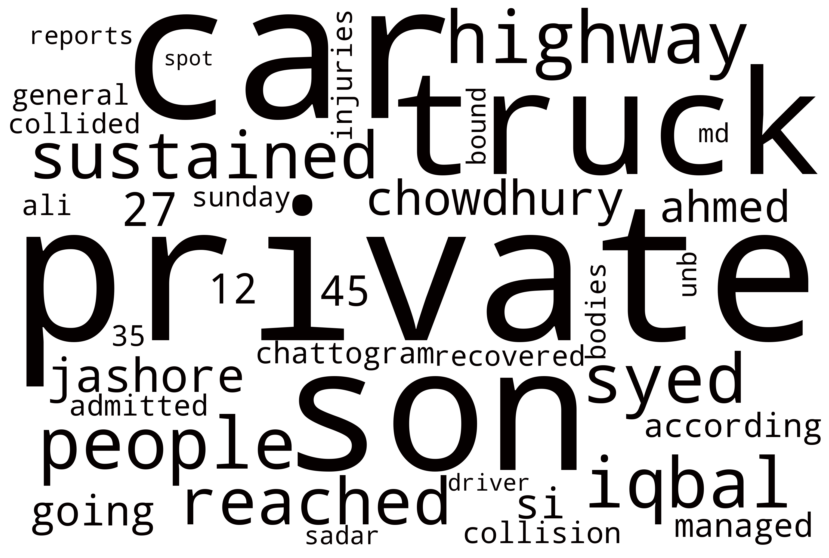

In [42]:
news_title = 'Four people killed in Jashore road accident' #other news titles can be accessed through news_tf_idf_df.columns
create_word_cloud( news_title)

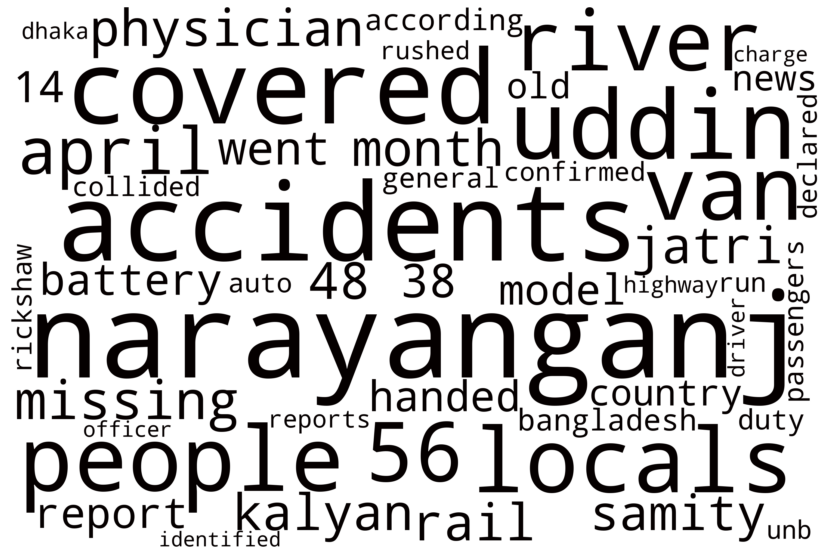

In [43]:
news_title = '2 killed in Fatullah road accident'
create_word_cloud(news_title)

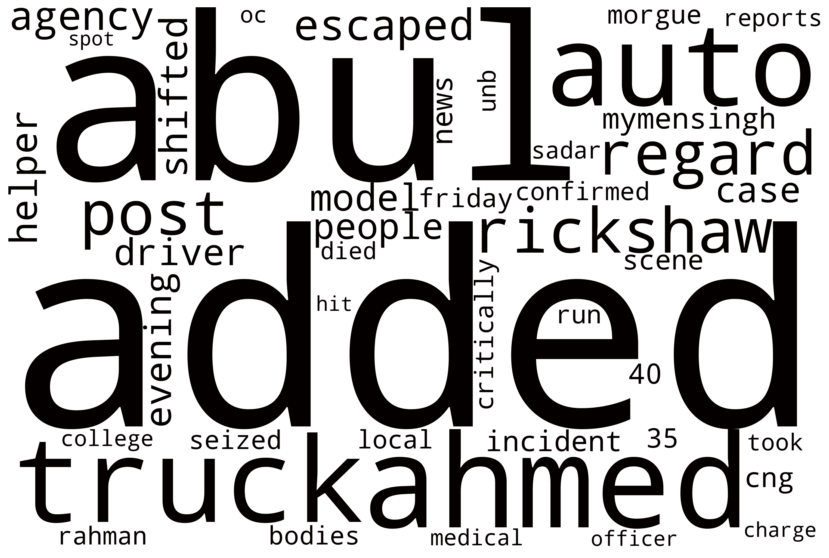

In [44]:
news_title = '2 killed as truck hits CNG-run auto-rickshaw'
create_word_cloud(news_title)